In [1]:
#정규화 0에서 1 사이 범위로 변환
import numpy as np

def normalize(x):
    x_max = np.max(x)
    x_min = np.min(x)
    return (x-x_min) / (x_max-x_min)

In [2]:
#표준화
def standardize(x):
    ave = np.average(x)
    std = np.std(x)
    return (x-ave) / std

In [3]:
#데이터 입력과 전처리
from sklearn import datasets

iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct) #샘플수

ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

Epoch:0/1000 Error_train:1.1022102047355276 Error_train:1.1025991164170672
Epoch:100/1000 Error_train:0.3388130847000747 Error_train:0.3288441579549648
Epoch:200/1000 Error_train:0.23807395954975685 Error_train:0.2286663115356082
Epoch:300/1000 Error_train:0.17585034141042902 Error_train:0.17312776748933836
Epoch:400/1000 Error_train:0.13676307631965506 Error_train:0.13874319653110093
Epoch:500/1000 Error_train:0.11108648864227429 Error_train:0.12045510455858538
Epoch:600/1000 Error_train:0.09420357936477948 Error_train:0.10504682406602672
Epoch:700/1000 Error_train:0.08076863010029516 Error_train:0.09748648214265687
Epoch:800/1000 Error_train:0.0723396052502605 Error_train:0.09229465237869361
Epoch:900/1000 Error_train:0.06583916443680667 Error_train:0.08753752535826011


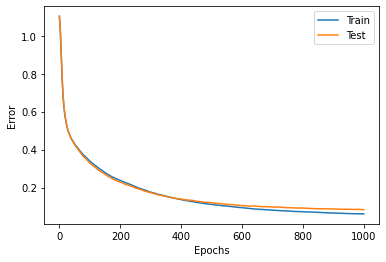

Accuracy Train: 98.66666666666667% Accuracy Test: 96.0%


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

#--Iris 데이터 읽어 들이기--
iris_data = datasets.load_iris()
input_data = iris_data.data
correct = iris_data.target
n_data = len(correct) #샘플 수

#--입력 데이터 표준화--
ave_input = np.average(input_data, axis=0)
std_input = np.std(input_data, axis=0)
input_data = (input_data - ave_input) / std_input

#--정답을 원핫 인코딩으로 변경--
correct_data = np.zeros((n_data, 3))
for i in range(n_data):
    correct_data[i, correct[i]] = 1.0
    
#--훈련 데이터와 테스트 데이터--
index = np.arange(n_data)
index_train = index[index%2 == 0]
index_test = index[index%2 != 0]

input_train = input_data[index_train, :] #훈련 데이터 입력
correct_train = correct_data[index_train, :] #훈련 데이터 정답
input_test = input_data[index_test, :] #테스트 데이터 입력
correct_test = correct_data[index_test, :] #테스트 데이터 정답

n_train = input_train.shape[0] #훈련 데이터 샘플 수
n_test = input_test.shape[0] #테스트 데이터 샘플 수

#--각 설정 값--
n_in = 4 #입력층 뉴런 수
n_mid = 25 #은닉층 뉴런 수
n_out = 3 #출력층 뉴런 수

wb_width = 0.1 #가중치와 편향 설정을 위한 정규분포 표준편차
eta = 0.01
epoch = 1000
batch_size = 8
interval = 100 #경과 표시 간격

#--각 층의 부모 클래스 생성--
class BaseLayer:
    def __init__(self, n_upper, n):
        self.w = wb_width * np.random.randn(n_upper, n) #가중치(행렬)
        self.b = wb_width * np.random.randn(n) #편향
        
        self.h_w = np.zeros(( n_upper, n )) + 1e-8
        self.h_b = np.zeros(n) + 1e-8
        
    def update(self, eta):
        self.h_w += self.grad_w * self.grad_w
        self.w -= eta / np.sqrt(self.h_w) * self.grad_w
        
        self.h_b += self.grad_b * self.grad_b
        self.b -= eta / np.sqrt(self.h_b) * self.grad_b
        
#은닉층
class MiddleLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u) #ReLU
    
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1) #ReLU 미분
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
#출력층
class OutputLayer(BaseLayer):
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        #소프트맥스 함수
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)
    
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T)
        
#드롭아웃 구현
class Dropout:
    def __init__(self, dropout_ratio):
        self.dropout_ratio = dropout_ratio
        
    def forward(self, x, is_train): #is_train: 학습할 때는 True
        if is_train:
            rand = np.random.rand(*x.shape) #난수 행렬
            self.dropout = np.where(rand > self.dropout_ratio, 1, 0)
            self.y = x * self.dropout #뉴런을 무작위로 무효화
        else:
            self.y = (1-self.dropout_ratio)*x
    
    def backward(self, grad_y):
        self.grad_x = grad_y * self.dropout

#각 층 초기화
middle_layer_1 = MiddleLayer(n_in, n_mid)
dropout_1 = Dropout(0.5)
middle_layer_2 = MiddleLayer(n_mid, n_mid)
dropout_2 = Dropout(0.5)
output_layer = OutputLayer(n_mid, n_out)

#순전파
def forward_propagation(x, is_train):
    middle_layer_1.forward(x)
    dropout_1.forward(middle_layer_1.y, is_train)
    middle_layer_2.forward(dropout_1.y)
    dropout_2.forward(middle_layer_2.y, is_train)
    output_layer.forward(dropout_2.y)
    
#역전파
def backpropagation(t):
    output_layer.backward(t)
    dropout_2.backward(output_layer.grad_x)
    middle_layer_2.backward(dropout_2.grad_x)
    dropout_1.backward(middle_layer_2.grad_x)
    middle_layer_1.backward(dropout_1.grad_x)
    
#가중치와 편향 수정
def update_wb():
    middle_layer_1.update(eta)
    middle_layer_2.update(eta)
    output_layer.update(eta)
    
#교차 엔트로피 오차 계산
def get_error(t, batch_size):
    return -np.sum(t * np.log(output_layer.y + 1e-7)) / batch_size

#오차 기록용
train_error_x = []
train_error_y = []
test_error_x = []
test_error_y = []

#학습과 경과 기록
n_batch = n_train // batch_size # 1에포크당 배치 수
for i in range(epoch):
    #오차 계측
    forward_propagation(input_train, 0)
    error_train = get_error(correct_train, n_train)
    forward_propagation(input_test, 0)
    error_test = get_error(correct_test, n_test)
    
    #오차 기록
    test_error_x.append(i)
    test_error_y.append(error_test)
    train_error_x.append(i)
    train_error_y.append(error_train)
    
    #경과 표시
    if i%interval == 0:
        print("Epoch:" + str(i) + "/" + str(epoch),
              "Error_train:" + str(error_train),
              "Error_train:" + str(error_test))
    #학습
    index_random = np.arange(n_train)
    np.random.shuffle(index_random) #인덱스 임의 섞기
    
    for j in range(n_batch):
        #미니 배치 샘플 추출
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x = input_train[mb_index, :]
        t = correct_train[mb_index, :]
        
        #순전파와 역전파
        forward_propagation(x, 1)
        backpropagation(t)
        
        #가중치와 편향 수정
        update_wb()
        
#기록된 오차를 그래프로 표시
plt.plot(train_error_x, train_error_y, label="Train")
plt.plot(test_error_x, test_error_y, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

#정답률 측정
forward_propagation(input_train, 0)
count_train = np.sum(np.argmax(output_layer.y, axis=1)
                    == np.argmax(correct_train,axis=1))

forward_propagation(input_test, 0)
count_test = np.sum(np.argmax(output_layer.y,axis=1)
                   == np.argmax(correct_test, axis=1))

print("Accuracy Train:", str(count_train/n_train*100) + "%",
      "Accuracy Test:", str(count_test/n_test*100) + "%")

In [4]:
samples = np.array([[5.0, 3.5, 1.0, 0.5],  # Iris1
                    [5.5, 2.5, 4.0, 1.0],  # Iris2
                    [7.0, 3.0, 6.0, 2.0],  # Iris3
                    [6.6, 2.5, 1.5, 0.2]   # Iris4
                   ])

# 표준화
ave_input = np.average(samples, axis=0)
std_input = np.std(samples, axis=0)
samples = (samples - ave_input) / std_input

# 분류
forward_propagation(samples, False)  # False는 훈련데이터가 아니라는 것을 표시
print(output_layer.y)

[[0.29182934 0.32675802 0.38141264]
 [0.29372196 0.32715066 0.37912737]
 [0.2916885  0.32619922 0.38211228]
 [0.29325318 0.32924585 0.37750097]]
